In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler

import shutil
import os

2024-07-29 22:38:13.263136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define the custom confusion matrix plotting function
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if title:
        plt.title(title)

In [4]:
# # Function to calculate false positive rate and false negative rate from confusion matrix
def calculate_fp_fn_rates(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    return fpr, fnr

In [5]:
df = pd.read_csv("encoded_data.csv")
df.shape

(379, 20547)

In [6]:
df.head()

,Unnamed: 0,sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,...,pathologic_N,pathologic_T,patient_id,sample_type_id,OS,DSS,PFI,gender_MALE,tissue_prospective_collection_indicator_YES,vital_status_LIVING
0,0,TCGA-FP-A4BE-01,1.224808,-1.747726,-0.531035,-0.257772,0.019122,-0.37631,-0.627894,0.050754,...,0,6,A4BE,1,0,0.0,0,1.0,1.0,1.0
1,1,TCGA-BR-8081-01,0.614508,-0.110026,-0.531035,0.026728,-0.550378,-0.39861,-0.846094,1.182054,...,0,8,8081,1,0,0.0,0,0.0,1.0,1.0
2,3,TCGA-IN-7806-01,2.248808,4.360074,-0.531035,0.252328,-0.463778,-0.76811,-0.311694,0.710954,...,1,6,7806,1,0,0.0,0,1.0,1.0,1.0
3,5,TCGA-RD-A8N6-01,1.744208,6.345474,-0.531035,-0.058472,-0.000678,0.00489,0.246706,1.308254,...,2,3,A8N6,1,1,1.0,1,0.0,0.0,0.0
4,6,TCGA-D7-8575-01,-0.217192,2.179874,-0.037735,0.202628,-0.074578,0.59279,1.296006,-1.005546,...,2,6,8575,1,1,1.0,1,1.0,1.0,0.0


In [7]:
df = df.drop(['Unnamed: 0', 'sample', 'patient_id'], axis=1)

### Correlation matrix

comment out for now for runtime

In [8]:
# correlation_matrix = df.corr()[['DSS']]
# print(correlation_matrix)

In [9]:
# correlation_matrix

In [10]:
# # Reset the index to get a long-form DataFrame
# correlation_pairs = correlation_matrix.reset_index()
# correlation_pairs.columns = ['Feature', 'Correlation with DSS']

# # Add a numerical index for the features
# correlation_pairs['Feature Index'] = correlation_pairs.index

# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=correlation_pairs, x='Feature Index', y='Correlation with DSS', size='Correlation with DSS', hue='Correlation with DSS', palette='coolwarm', legend=None)
# plt.title('Scatter Plot of Correlations with DSS')
# plt.xlabel('Feature Index')
# plt.ylabel('Correlation with DSS')
# plt.tight_layout()
# plt.show()

In [11]:
# high_correlation = correlation_matrix[correlation_matrix['DSS'] > 0.5]
# high_correlation

In [12]:
# low_correlation = correlation_matrix[correlation_matrix['DSS'] < -0.5]
# low_correlation

In [13]:
# flop = correlation_matrix.loc['PRTG']
# print("Chat, PRTG has a correlation to DSS of", flop)

### must drop these columns since they are also binary outcome variables about survival

In [14]:
cols_to_drop = [
    'OS',
    'PFI',
    'vital_status_LIVING'
]

In [15]:
df = df.drop(columns=cols_to_drop)

In [16]:
df['DSS'] = df['DSS'].astype(int)

In [17]:
df.iloc[:, -11:]

,icd_o_3_histology,icd_o_3_site,neoplasm_histologic_grade,other_dx,pathologic_M,pathologic_N,pathologic_T,sample_type_id,DSS,gender_MALE,tissue_prospective_collection_indicator_YES
0,0,1,2,0,0,0,6,1,0,1.0,1.0
1,0,2,1,0,0,0,8,1,0,0.0,1.0
2,2,0,2,0,0,1,6,1,0,1.0,1.0
3,1,3,2,0,0,2,3,1,1,0.0,0.0
4,3,1,2,0,0,2,6,1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
374,0,0,1,0,0,4,6,1,0,0.0,1.0
375,1,3,1,0,0,0,3,1,1,1.0,0.0
376,5,0,1,0,0,1,3,1,1,1.0,1.0
377,0,1,2,0,0,0,8,1,0,0.0,1.0


In [18]:
# Assuming df is your DataFrame
columns_to_drop = df.iloc[:, -11:].columns
columns_to_keep = ['DSS']

# Filter out 'DSS' from the columns to drop
columns_to_drop = [col for col in columns_to_drop if col not in columns_to_keep]

# Drop the columns
df = df.drop(columns=columns_to_drop)

In [19]:
df.head()

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,DSS
0,1.224808,-1.747726,-0.531035,-0.257772,0.019122,-0.37631,-0.627894,0.050754,-0.423399,2.842428,...,-1.587117,0.393267,-0.70569,-0.439777,-1.479386,0.645873,0.216105,-1.013033,-0.252312,0
1,0.614508,-0.110026,-0.531035,0.026728,-0.550378,-0.39861,-0.846094,1.182054,0.615701,-0.477872,...,0.588183,1.038367,-1.28139,-0.140877,-0.249686,1.188673,1.518105,2.037867,-0.196712,0
2,2.248808,4.360074,-0.531035,0.252328,-0.463778,-0.76811,-0.311694,0.710954,-0.423399,0.375328,...,-0.159517,-0.831733,1.79511,0.444823,-0.739786,-0.595127,0.730305,1.368767,-0.576912,0
3,1.744208,6.345474,-0.531035,-0.058472,-0.000678,0.00489,0.246706,1.308254,-0.423399,1.110628,...,-0.935417,-0.807333,1.84101,0.979423,1.017814,-0.529927,-0.513095,2.006967,3.034988,1
4,-0.217192,2.179874,-0.037735,0.202628,-0.074578,0.59279,1.296006,-1.005546,2.770901,0.414428,...,-1.587117,0.124467,1.46431,-0.060977,-0.750086,-1.555027,-0.944295,0.797967,0.196288,1


In [20]:
# Get the counts of each class in the 'dss' column
dss_counts = df['DSS'].value_counts().reset_index()

# Rename the columns for clarity
dss_counts.columns = ['Class', 'Count']

# Display the DataFrame
dss_counts


,Class,Count
0,0,283
1,1,96


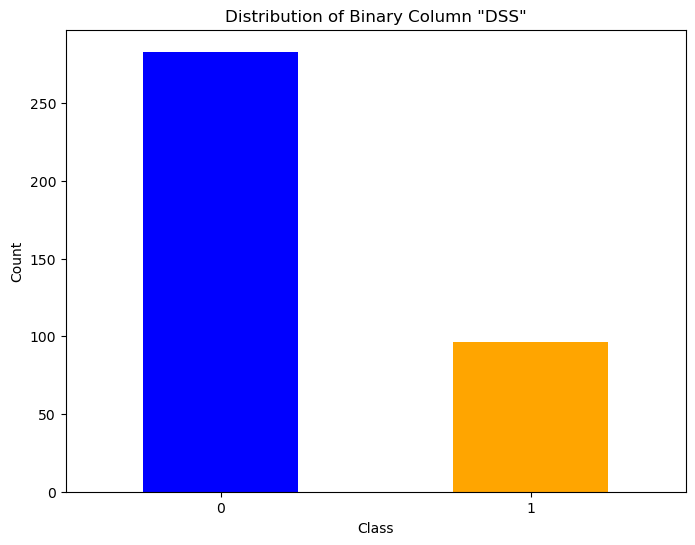

In [21]:
# Plot the distribution of the binary column 'dss'
plt.figure(figsize=(8, 6))
df['DSS'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Binary Column "DSS"')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [22]:
df.head()

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,DSS
0,1.224808,-1.747726,-0.531035,-0.257772,0.019122,-0.37631,-0.627894,0.050754,-0.423399,2.842428,...,-1.587117,0.393267,-0.70569,-0.439777,-1.479386,0.645873,0.216105,-1.013033,-0.252312,0
1,0.614508,-0.110026,-0.531035,0.026728,-0.550378,-0.39861,-0.846094,1.182054,0.615701,-0.477872,...,0.588183,1.038367,-1.28139,-0.140877,-0.249686,1.188673,1.518105,2.037867,-0.196712,0
2,2.248808,4.360074,-0.531035,0.252328,-0.463778,-0.76811,-0.311694,0.710954,-0.423399,0.375328,...,-0.159517,-0.831733,1.79511,0.444823,-0.739786,-0.595127,0.730305,1.368767,-0.576912,0
3,1.744208,6.345474,-0.531035,-0.058472,-0.000678,0.00489,0.246706,1.308254,-0.423399,1.110628,...,-0.935417,-0.807333,1.84101,0.979423,1.017814,-0.529927,-0.513095,2.006967,3.034988,1
4,-0.217192,2.179874,-0.037735,0.202628,-0.074578,0.59279,1.296006,-1.005546,2.770901,0.414428,...,-1.587117,0.124467,1.46431,-0.060977,-0.750086,-1.555027,-0.944295,0.797967,0.196288,1


In [23]:
X = df.drop(['DSS'], axis=1)
y = df['DSS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


In [24]:
X['PRTG']

0     -1.848062
1     -0.264462
2     -1.018662
3      1.823238
4      0.472838
         ...   
374    1.665238
375    3.117638
376    1.096838
377   -1.559562
378    2.492838
Name: PRTG, Length: 379, dtype: float64

## NN time

In [25]:
# Define the log directory
log_dir = "logs"

# Clear the log directory
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# Create the log directory if it doesn't exist
os.makedirs(log_dir)

In [26]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### after tensorboard evaluation, it seems that 64 nodes and 6 layers seems to be the best combo

In [28]:
# Define custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [32]:
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import AUC


# Ensure y_train is a NumPy array
y_train = np.array(y_train)

k = 5  # Number of folds for cross-validation

# Placeholder for cross-validation results and models
cv_results = []
models = []

kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_no = 1
fold_metrics = []
start_time = time.time()
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define the model
    model = Sequential()

    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    NAME = "deadNN-fold-{}".format(fold_no)
    tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)

    # Compile the model with accuracy, AUC, and F1 score as metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc'), F1Score()])

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32,
                        validation_data=(X_val_fold, y_val_fold), verbose=1,
                        callbacks=[tensorboard, early_stopping])

    # Evaluate the model on the validation fold
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracy = scores[1]
    auc = scores[2]
    f1 = scores[3]
    print(f'Score for fold {fold_no}: Accuracy of {accuracy*100:.2f}%, AUC of {auc*100:.2f}%, F1 Score of {f1*100:.2f}%')
    fold_metrics.append({'fold': fold_no, 'accuracy': accuracy, 'auc': auc, 'f1': f1})

    # Save the model for this fold
    models.append(model)

    fold_no += 1


Training for fold 1 ...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.6065 - auc: 0.5764 - f1_score: 0.3427 - loss: 1.1574 - val_accuracy: 0.6393 - val_auc: 0.4263 - val_f1_score: 0.2011 - val_loss: 1.1629
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8850 - auc: 0.9172 - f1_score: 0.2814 - loss: 0.3489 - val_accuracy: 0.6721 - val_auc: 0.6042 - val_f1_score: 0.2011 - val_loss: 0.9043
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9443 - auc: 0.9813 - f1_score: 0.2591 - loss: 0.1914 - val_accuracy: 0.7049 - val_auc: 0.5665 - val_f1_score: 0.2356 - val_loss: 1.1572
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9900 - auc: 0.9980 - f1_score: 0.2432 - loss: 0.0443 - val_accuracy: 0.7049 - val_auc: 0.4840 - val_f1_score: 0.1556 - val_loss: 1.1815
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9882 - auc: 0.9999 - f1_score: 0.2662 - loss: 0.0253 - val_accuracy: 0.7377 - val_auc: 0.5433 - val_f1_score: 0

In [33]:

# Print all metrics for each fold
print("\nMetrics for each fold:")
for metrics in fold_metrics:
    print(f"Fold {metrics['fold']}: Accuracy: {metrics['accuracy']*100:.2f}%, AUC: {metrics['auc']*100:.2f}%, F1 Score: {metrics['f1']*100:.2f}%")

# Select the best fold based on desired criteria (e.g., highest AUC, then highest Accuracy)
best_fold = max(fold_metrics, key=lambda x: (x['auc'], x['accuracy'], x['f1']))
best_model = models[best_fold['fold']]

print(f'\nBest fold: {best_fold["fold"]} with Accuracy: {best_fold["accuracy"]*100:.2f}%, AUC: {best_fold["auc"]*100:.2f}%, F1 Score: {best_fold["f1"]*100:.2f}%')

# Use the best model to make predictions
# Example prediction: best_model.predict(new_data)


Metrics for each fold:
Fold 1: Accuracy: 75.41%, AUC: 58.73%, F1 Score: 15.82%
Fold 2: Accuracy: 73.77%, AUC: 45.99%, F1 Score: 15.97%
Fold 3: Accuracy: 67.21%, AUC: 63.10%, F1 Score: 17.69%
Fold 4: Accuracy: 76.67%, AUC: 61.02%, F1 Score: 19.78%
Fold 5: Accuracy: 55.00%, AUC: 42.55%, F1 Score: 25.32%

Best fold: 3 with Accuracy: 67.21%, AUC: 63.10%, F1 Score: 17.69%


In [52]:
y_pred_prob = best_model.predict(X_test).flatten()
end_time = time.time()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [53]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)

# print(f'Test Loss: {loss}')
# print(f'Test Accuracy: {accuracy}')

### Understanding Thresholds in the `roc_curve` Function

The `roc_curve` function from `sklearn.metrics` evaluates the performance of a binary classifier by examining various thresholds. Here's how it determines and uses these thresholds:

1. **Predicted Probabilities (`y_pred`):**
   - These are the continuous output values from your classifier, representing the probability or confidence that a given instance belongs to the positive class.

2. **Unique Sorted Thresholds:**
   - The `roc_curve` function extracts all unique values from `y_pred` and sorts them in descending order. These unique values become the candidate thresholds.
   
3. **Threshold Evaluation:**
   - For each unique threshold, the function calculates the True Positive Rate (TPR) and False Positive Rate (FPR).
   - By iterating over the sorted unique values, the function evaluates the classifier's performance at each threshold.

AUC: 0.7260049220672682
Optimal threshold (Youden's J): 0.0063620307
Optimal threshold (Distance): 0.0063620307


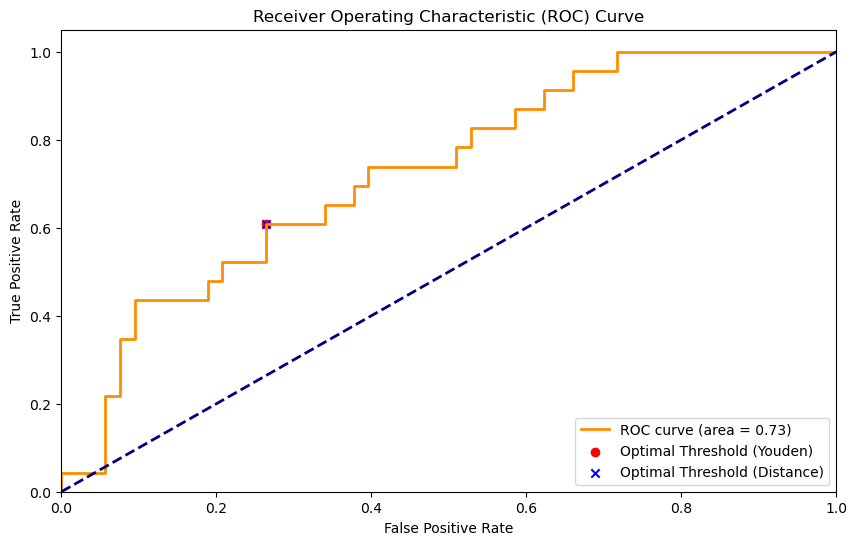

In [54]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Find the optimal threshold by maximizing Youden's J statistic
optimal_idx_youden = np.argmax(tpr - fpr)
optimal_threshold_youden = thresholds[optimal_idx_youden]
print("Optimal threshold (Youden's J):", optimal_threshold_youden)

# Find the optimal threshold by minimizing the distance to the top-left corner (0, 1)
optimal_idx_distance = np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))
optimal_threshold_distance = thresholds[optimal_idx_distance]
print("Optimal threshold (Distance):", optimal_threshold_distance)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot the optimal points
plt.scatter(fpr[optimal_idx_youden], tpr[optimal_idx_youden], marker='o', color='red', label='Optimal Threshold (Youden)')
plt.scatter(fpr[optimal_idx_distance], tpr[optimal_idx_distance], marker='x', color='blue', label='Optimal Threshold (Distance)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## optimal thesholds are the same

In [55]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Assume y_true contains the true binary labels

# # Function to calculate performance metrics
# def evaluate_threshold(threshold, outputs, true_labels):
#     binary_outputs = (outputs >= threshold).astype(int)
#     accuracy = accuracy_score(true_labels, binary_outputs)
#     precision = precision_score(true_labels, binary_outputs, zero_division=1)
#     recall = recall_score(true_labels, binary_outputs, zero_division=1)
#     f1 = f1_score(true_labels, binary_outputs, zero_division=1)
#     return accuracy, precision, recall, f1

# # Evaluate different thresholds
# thresholds = np.arange(0.1, 1.0, 0.1)
# for threshold in thresholds:
#     accuracy, precision, recall, f1 = evaluate_threshold(threshold, y_pred, y_test)
#     print(f"Threshold: {threshold:.1f} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")


In [56]:
# Set the threshold
threshold = optimal_threshold_youden

# Convert continuous outputs to binary
binary_outputs = (y_pred_prob >= threshold).astype(int)

# print("Continuous outputs:", y_pred)
# print("Binary outputs:", binary_outputs)

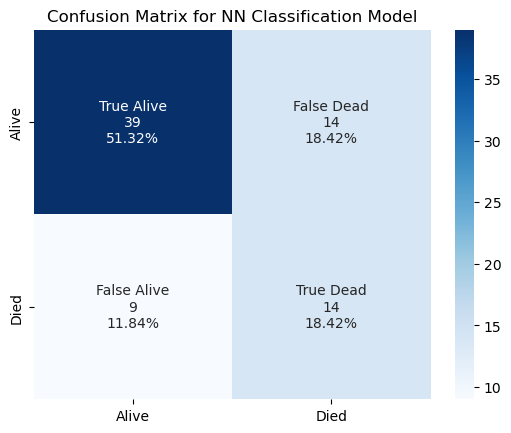

In [62]:
nn_report = classification_report(y_test, binary_outputs, output_dict=True)

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, binary_outputs)

# Define the category names
categories = ['Alive', 'Died']
labels = ['True Alive', 'False Dead', 'False Alive', 'True Dead']
# Plot the confusion matrix
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      title='Confusion Matrix for NN Classification Model')
plt.show()

In [63]:
np.ravel(binary_outputs)

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [64]:
np.array(y_test)

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [71]:
nn_metrics = []
# LassoCV model metrics
fpr, fnr = calculate_fp_fn_rates(cf_matrix)
nn_metrics.append({
    'model': 'NN',
    'estimation_time_sec': round(end_time - start_time, 2),
    'accuracy': round(nn_report['accuracy'], 3),
    'f1-score': round(nn_report['weighted avg']['f1-score'], 3),
    'auc': round(roc_auc, 3),
    'false_positive_rate': round(fpr, 3),
    'false_negative_rate': round(fnr, 3)
})

nn_metrics_df = pd.DataFrame(nn_metrics)
nn_metrics_df

,model,estimation_time_sec,accuracy,f1-score,auc,false_positive_rate,false_negative_rate
0,NN,369.71,0.697,0.705,0.726,0.264,0.391


## so far this is better than before the NN

In [73]:
# write results to csv

nn_metrics_df.to_csv('metrics.csv', mode='a', index=False, header=False)